# W207 - Final Project
## Scott Abramson, Brett Brandom, Maria Jose Healey, Yidai Yao

### <span style="color:chocolate"> Pawpularity:predicting engagement with a pet's profile based on the photograph for that profile.  </span>

#### ``Objective``

This is based on a kaggle competition. The objective is to score pet photos on a "Cuteness Meter" so that pets up for adoption have a higher chance of being adopted.

#### ``Introduction``

TBD

#### ``Data``

Dataset downloaded from Kaggle competition.

### Step 1: Import libraries

In [8]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

IMAGE_PATH = '/users/scottabramson/MIDS_LOCAL_DATA/pawpularity_data/train/'
LABEL_PATH = '/users/scottabramson/MIDS_LOCAL_DATA/pawpularity_data/'

### Step 2: Read Data

In [10]:
# read meta_data
meta_data = pd.read_csv(
    LABEL_PATH + 'train.csv'
)

print('Shape of Meta Data:', meta_data.shape)
meta_data.head()

Shape of Meta Data: (9912, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

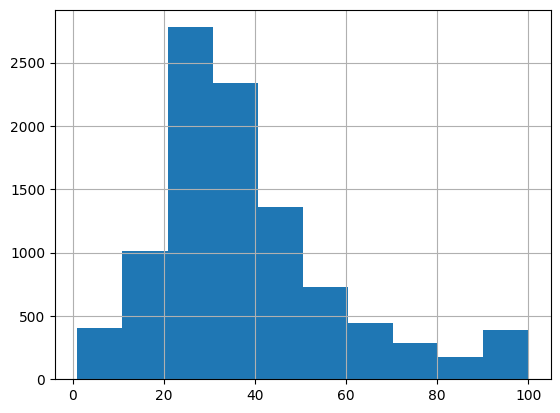

In [18]:
# Look at the distribution of labels from 0 - 100
meta_data['Pawpularity'].hist()
meta_data['Pawpularity'].describe()



In [19]:
meta_data['Pawpularity'].value_counts().sort_values()

Pawpularity
99      4
1       4
90      7
97      8
98     10
     ... 
29    304
31    312
26    316
30    318
28    318
Name: count, Length: 100, dtype: int64

In [20]:
# Check the ends of the distribution
print("Count of Pawpularity Scores of 1: ",meta_data['Pawpularity'].value_counts()[1])
print("Count of Pawpularity Scores of 1: ",meta_data['Pawpularity'].value_counts()[100])

Count of Pawpularity Scores of 1:  4
Count of Pawpularity Scores of 1:  288


In [21]:
# Evaluate the distribution of meta data values for all images
label_metadata = meta_data
label_metadata['Meta_Sum'] = label_metadata.iloc[:, -12:-2].sum(axis=1)
label_metadata.sort_values(by='Meta_Sum')
print("Distribution of Meta Data Sums per Image\n",label_metadata['Meta_Sum'].value_counts())
label_metadata.head()

totals = []
counts = []
for i in range(8) :
    totals.append(label_metadata.loc[label_metadata['Meta_Sum'] == i, 'Pawpularity'].sum())
    counts.append(label_metadata['Meta_Sum'].value_counts()[i])
    print("Meta Sum :", i, "Count :", counts[i], "Pawpularity Sum :", totals[i], "Average :", totals[i]/counts[i])



Distribution of Meta Data Sums per Image
 Meta_Sum
3    4763
4    1718
2    1319
5    1130
1     656
6     197
0      76
7      48
8       5
Name: count, dtype: int64
Meta Sum : 0 Count : 76 Pawpularity Sum : 2465 Average : 32.43421052631579
Meta Sum : 1 Count : 656 Pawpularity Sum : 25040 Average : 38.170731707317074
Meta Sum : 2 Count : 1319 Pawpularity Sum : 49651 Average : 37.642911296436694
Meta Sum : 3 Count : 4763 Pawpularity Sum : 181592 Average : 38.12555112324166
Meta Sum : 4 Count : 1718 Pawpularity Sum : 65965 Average : 38.39639115250291
Meta Sum : 5 Count : 1130 Pawpularity Sum : 42760 Average : 37.84070796460177
Meta Sum : 6 Count : 197 Pawpularity Sum : 7454 Average : 37.83756345177665
Meta Sum : 7 Count : 48 Pawpularity Sum : 1937 Average : 40.354166666666664


### Step 3: EDA

### EDA

It's pretty clear that there will be variance in the size, orientation and possibly the resolution of the photos.

### Step 4: Preprocess Data

In [24]:
def prepare_data(image_path, label_path) :

    train_images = os.listdir(image_path)
    train_df = pd.read_csv(label_path + 'train.csv')

    train_df = train_df.set_index('Id')
    file_names = []
    labels = []

    for index in train_df.index:
        file_name = image_path + index + '.jpg'
        label = train_df.loc[index]['Pawpularity']
        file_names.append(file_name)
        labels.append(label/1.0)

    # Use sklearn function to split data
    train_files, val_files, labels_train, labels_val = train_test_split(file_names, labels, test_size=0.2, random_state=137)
    
    return train_files, val_files, labels_train, labels_val

def process_file_names(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.image.resize(img, [224,224])
   
    # TO DO: image augmentation
    # Adjust Brightness to a copy of the images
    img_augm = tf.image.adjust_brightness(img, delta=3)

    # adjust contrast to the copy
    img_augm = tf.image.adjust_contrast(img_augm, contrast_factor=3)

    # random flip the copy
    img_augm = tf.image.random_flip_left_right(img_augm)
    
    # Concatenate the augmented images with the original images
    # Keep the labels the same
    img = tf.concat([img, img_augm], axis=0)
    label_augm = label
    label = tf.stack([label, label_augm], axis=0)

    # rescale labels so between 0 and 1
    return img, label/100.01

train_files, val_files, labels_train, labels_val = prepare_data(IMAGE_PATH, LABEL_PATH)

train_dataset = tf.data.Dataset.from_tensor_slices((train_files, labels_train))
train_dataset = train_dataset.map(process_file_names)
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, labels_val))
val_dataset = val_dataset.map(process_file_names)


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    return ds

train_dataset = configure_for_performance(train_dataset)
val_dataset = configure_for_performance(val_dataset)
train_dataset



<_BatchDataset element_spec=(TensorSpec(shape=(None, 448, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

### Preprocessing Data

I'm going to assume we perform normalization in the EDA step for now.  Also assuming images coming into the preprocessing layer should all have a similar shape and quality for now.

This section for now is going to focus on various augmentation approaches.

I'm going to start with the HW10 helper code as a baseline.


### Step 5: Modeling and Evaluation

### <span style="color:chocolate"> Baseline Model  </span>

### <span style="color:chocolate"> Improvement on Baseline Model  </span>

### Step 6: Conclusion

TBD